## SQL



### 1. Активные студенты. Задача

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких проверочных заданий. 

Дана таблица

| Название атрибута | Тип атрибута | Смысловое значение                          |
|-------------------|--------------|---------------------------------------------|
| `st_id`           | `int`        | ID ученика                                  |
| `timest`          | `timestamp`  | Время решения карточки                      |
| `correct`         | `bool`       | Правильно ли решена задача?                 |
| `subject`         | `text`       | Дисциплина, в которой находится задача.     |



Необходимо написать оптимальный запрос, который даст информацию о количестве активных студентов.
NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

### 1. Активные студенты. Решение

##### Вар 1:

    WITH diligent_studs AS (

                         SELECT st_id
                         
                           FROM peas
                           
                          WHERE correct=TRUE
                          
                          GROUP BY st_id
                          
                         HAVING count(timest)>=20
                         
                         )

    SELECT count(*) AS diligent_studs_cnt
      FROM diligent_studs
  
  
##### Вар 2:

    SELECT count(*) AS diligent_studs_cnt

      FROM (

               SELECT st_id

                 FROM peas

                WHERE correct = TRUE

                GROUP BY st_id

               HAVING COUNT(timest) >= 20

             ) AS diligent_studs;


### 2. Оптимизация воронки. Задача

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 задач в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.


Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

ARPU

ARPAU 

CR в покупку 

СR активного пользователя в покупку (активный = решил более 10 задач)

CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике (активный по математике = решил более 2 задач по математике)


### 2.2 Оптимизация воронки. Решение


#### Создаем CTE с инфо по активности пользователей - в том числе отделяем активных по математике

WITH active_studes_pivot AS (


    SELECT st_id,
    
           SUM(CASE WHEN correct=TRUE THEN 1 ELSE 0 END) AS correct_tasks,
           
           SUM(CASE WHEN subject = 'Math' AND correct=TRUE THEN  1 ELSE 0 END) AS correct_math_tasks,
           
           COUNT(correct) AS attempts,
           
           CASE WHEN SUM(CASE 
                         WHEN correct=TRUE 
                         THEN 1 
                         ELSE 0 
                          END )>10 THEN 1 ELSE 0 END AS active_stud,
          
           CASE WHEN SUM(CASE 
                         WHEN subject = 'Math' 
                          AND correct=TRUE 
                         THEN  1 
                         ELSE 0 
                          END )>=2 THEN 1 ELSE 0 END AS active_math_stud       
 
 
      FROM peas
     GROUP by st_id
 
     ),
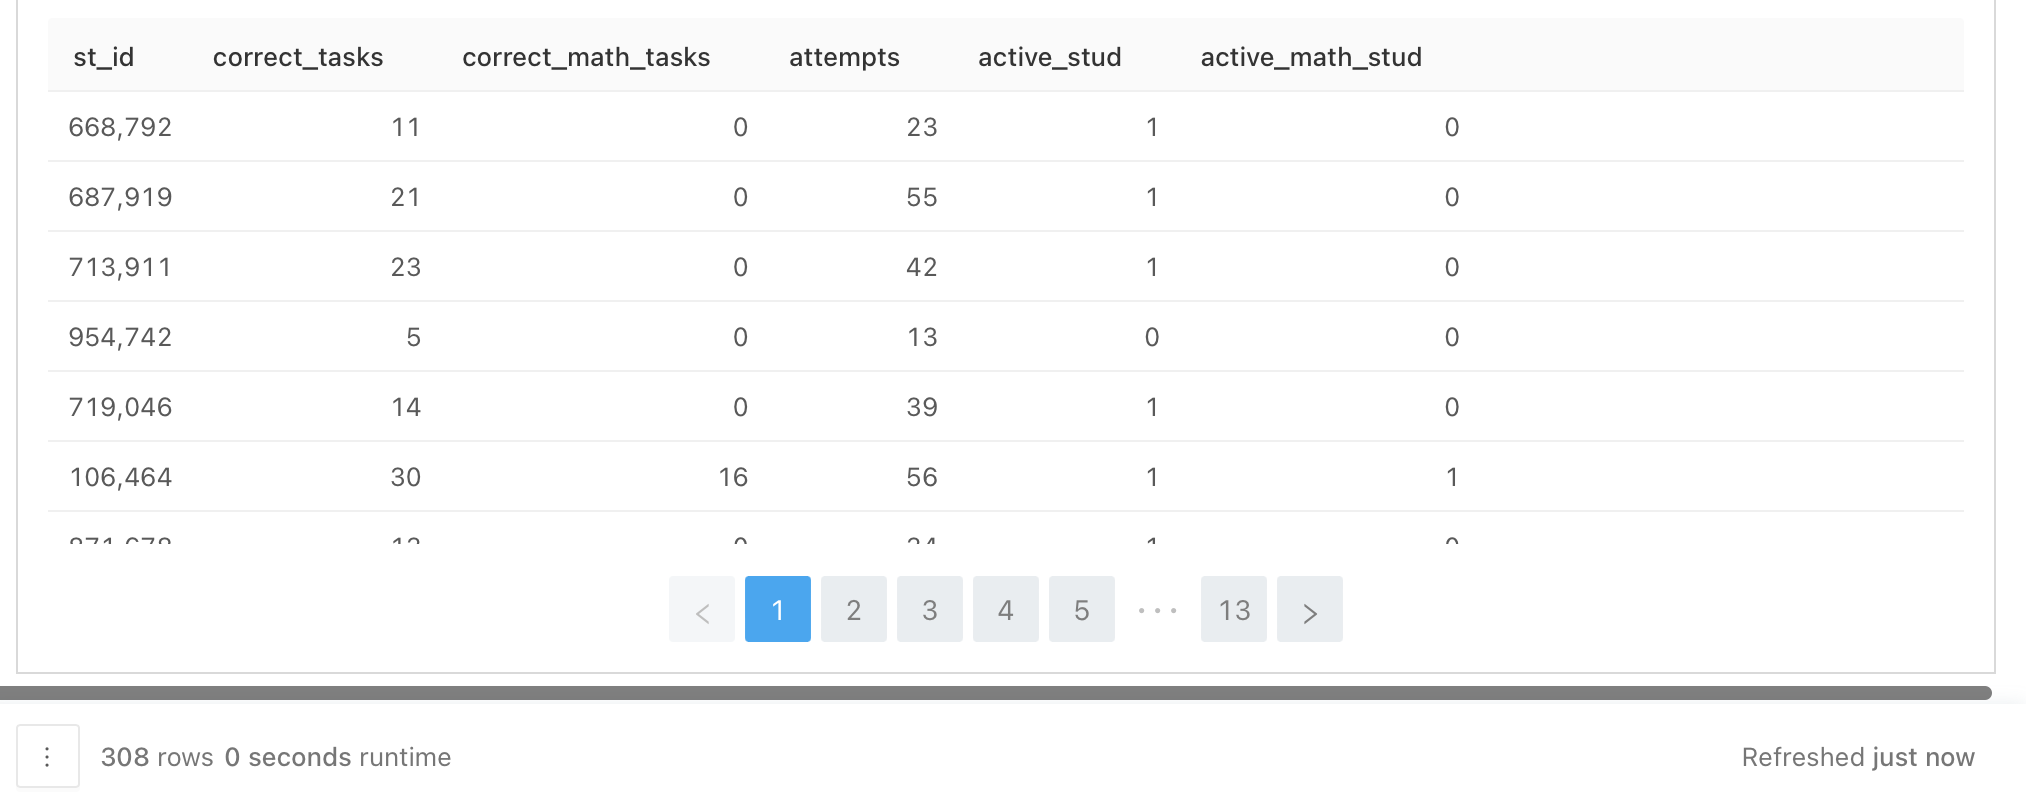 



   

#### Создаем CTE с инфо по оплатам - объединяя тех, кто купил сразу несколько курсов. Также создаем столбик с инфо, был ли куплен курс по математике.

##### Тут обнаруживаем 2-х пользователей, которые купили курс, но не проявляли активность до этого

courses_sale_pivot AS (

    SELECT st_id,
           SUM(money) AS revenue,
           SUM(CASE 
               WHEN subject='Math' 
               THEN 1 
               ELSE 0 
                END ) AS math_course 
            
     FROM final_project_check
    GROUP BY st_id

    )

![image.png](https://imgur.com/Wpgmx2Z.png)




#### Выводим нужное нам инфо

     SELECT SUM(revenue)/COUNT(st_id) AS ARPU,
            SUM(revenue)/SUM(active_stud) AS ARPAU,
            COUNT(revenue) * 100.0 / CAST(COUNT(st_id) AS FLOAT) AS cr_purchases,
            COUNT(revenue) * 100.0 / CAST(SUM(active_stud) AS FLOAT) AS cr_active_purchases,
            SUM(math_course) * 100 /SUM(active_math_stud) AS cr_active_math_purchases
       FROM studs

       LEFT JOIN active_studes_pivot AS asp
      USING (st_id)
   
       LEFT JOIN courses_sale_pivot AS csp 
      USING (st_id)
  
      GROUP BY test_grp
      
 ![image.png](https://imgur.com/2G609DI.png)